#### Ioway Creek Spatial Agreggation

In [ ]:
import os
import xarray as xr
import geopandas as gp
import pandas as pd
import numpy as np
import sparse

import hvplot.pandas
import hvplot.xarray
import dask
import cf_xarray

import intake
import cartopy.crs as ccrs
from shapely.geometry import Polygon

import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dask
import sparse
from shapely.geometry import Polygon
import pandas as pd
import hvplot.pandas
import cartopy.crs as ccrs

import geopandas as gp
from pynhd import NLDI, WaterData

# USGS gage 05470500
gage_id = '05470500'
nldi = NLDI()

# Retrieve the watershed basins (HUC12) associated with the specified USGS gage
del_basins = nldi.get_basins(gage_id)

# Create an instance of the WaterData class for the Watershed Boundary Dataset (WBD12)
wbd12 = WaterData('wbd12')

# Retrieve watershed boundaries (HUC12) based on the geometry of the retrieved basins
huc12_basins = wbd12.bygeom(del_basins.geometry[0])

# Display the retrieved watershed basins
print(huc12_basins)

# Save the GeoDataFrame to a shapefile
shapefile_path = r'C:\Users\adi10136\Desktop\CONUS404\HUC12_05470500'
huc12_basins.to_file(shapefile_path)

print(f"HUC12 basins shapefile saved to {shapefile_path}")


gage_id = '05470500'
nldi = NLDI()
del_basins = nldi.get_basins(gage_id)
wbd12 = WaterData('wbd12')
huc12_basins = wbd12.bygeom(del_basins.geometry[0])


shapefile_path = 'huc12_basins.shp'
huc12_basins.to_file(shapefile_path)


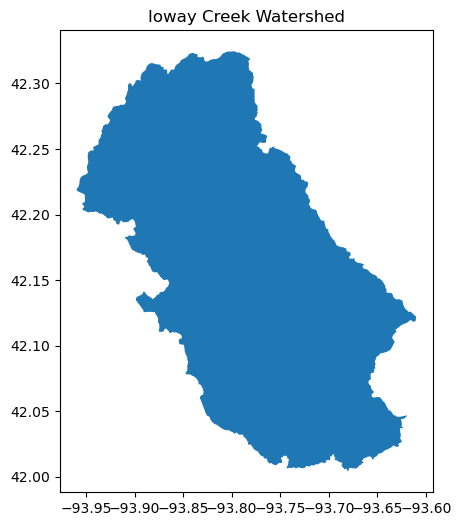

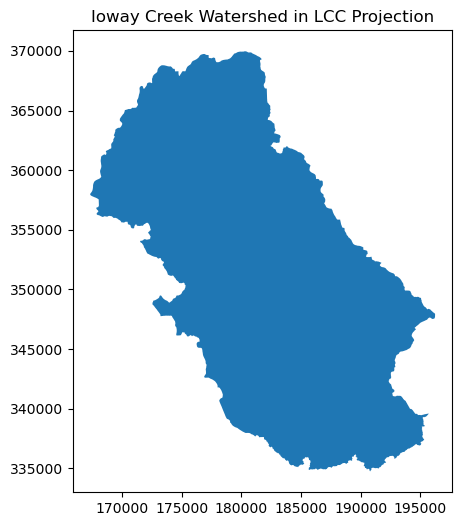

Bounding box: (167314.3470439166, 334747.9735910201, 196237.47384634422, 369969.3748647141)
Columns in regions_df: Index(['Name', 'geometry'], dtype='object')
Columns in grid_df: Index(['geometry', 'y', 'x'], dtype='object')
Regions_df 'Name' column values: ['Ioway_Creek']
Columns in overlay: Index(['y', 'x', 'Name', 'geometry'], dtype='object')
Sample data in overlay:           y         x         Name  \
0  336000.0  180000.0  Ioway_Creek   
1  336000.0  184000.0  Ioway_Creek   
2  336000.0  188000.0  Ioway_Creek   
3  336000.0  192000.0  Ioway_Creek   
4  336000.0  196000.0  Ioway_Creek   

                                            geometry  
0  POLYGON ((-5180654.650 342876.922, -5181205.40...  
1  POLYGON ((-5180654.650 342876.922, -5181033.88...  
2  POLYGON ((-5181033.880 338485.817, -5181411.33...  
3  POLYGON ((-5181411.339 334094.558, -5181787.02...  
4  POLYGON ((-5181787.025 329703.146, -5181899.53...  
Overlay 'Name' column values: ['Ioway_Creek']
Sparsity: 0.70833333333

C:\Users\adi10136\AppData\Local\anaconda3\Lib\site-packages\sparse\_common.py:209: RuntimeWarning: Nan will not be propagated in matrix multiplication
  warnings.warn("Nan will not be propagated in matrix multiplication", RuntimeWarning, stacklevel=1)


KeyError: "not all values found in index 'Name'"

In [19]:
# Open the hytest data intake catalog
hytest_cat = intake.open_catalog("https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml")

# Open the conus404 sub-catalog
cat = hytest_cat['conus404-catalog']

# Select the dataset you want to read into your notebook and preview its metadata
dataset = 'conus404-daily-osn' 



ds = cat['conus404-daily-osn'].to_dask()
ds = cat[dataset].to_dask()

# Define the watershed and shapefile path for Ioway Creek
WATERSHED = "Ioway Creek"
shapefile_path = f'C:\\Users\\adi10136\\Desktop\\Runoff Analysis\\Shp\\{WATERSHED}\\layers\\globalwatershed.shp'

# Read the shapefile into a GeoDataFrame
Ioway_Creekgdf = gp.read_file(shapefile_path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 6))
Ioway_Creekgdf.plot(ax=ax)
plt.title(f"{WATERSHED} Watershed")
plt.show()

# Use the new GeoDataFrame for further analysis
regions_df = Ioway_Creekgdf

# Ensure the CRS is set to EPSG:4326
crs_orig = 'EPSG:4326'
if regions_df.crs != crs_orig:
    regions_df = regions_df.to_crs(crs_orig)

x = 'x'
y = 'y'

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe,
                            central_longitude=-96,
                            central_latitude=39,
                            standard_parallels=(33, 45))

lcc_wkt = lcc.to_wkt()

regions_df = regions_df.to_crs(lcc_wkt)

fig, ax = plt.subplots(figsize=(12, 6))
regions_df.plot(ax=ax)
plt.title(f"{WATERSHED} Watershed in LCC Projection")
plt.show()

bbox = tuple(regions_df.total_bounds)
print("Bounding box:", bbox)

ds = ds.sel(x=slice(bbox[0], bbox[2]), y=slice(bbox[1], bbox[3]))

var = 'ACRAINLSM'

grid = ds[[var]].drop(['time', 'lon', 'lat', var]).reset_coords().load()
grid = grid.cf.add_bounds([x, y])
points = grid.stack(point=(y, x))

def bounds_to_poly(x_bounds, y_bounds):
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.x_bounds,
    points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

grid_df = gp.GeoDataFrame(
    data={"geometry": boxes.values, "y": boxes[y], "x": boxes[x]},
    index=boxes.indexes["point"],
    crs=lcc_wkt
)

crs_area = "EPSG:6931"

regions_df = regions_df.to_crs(crs_area)
grid_df = grid_df.to_crs(crs_area)

region_name = 'Name'  # Use 'Name' instead of 'name'

# Check the columns in regions_df and grid_df
print("Columns in regions_df:", regions_df.columns)
print("Columns in grid_df:", grid_df.columns)

# Ensure the Name column exists in regions_df
print("Regions_df 'Name' column values:", regions_df['Name'].unique())

overlay = grid_df.overlay(regions_df, keep_geom_type=True)

# Check the columns and sample data in overlay
print("Columns in overlay:", overlay.columns)
print("Sample data in overlay:", overlay.head())

# Ensure the Name column exists in overlay
print("Overlay 'Name' column values:", overlay['Name'].unique())

sparsity = len(overlay) / (len(grid_df) * len(regions_df))
print("Sparsity:", sparsity)

# Ensure 'Name' exists in overlay before grouping
if region_name in overlay.columns:
    area_grouped = overlay.geometry.area.groupby(overlay[region_name]).sum().nlargest(10) / 1e6  # km2
    print(area_grouped)
else:
    print(f"Column '{region_name}' not found in overlay")

# Ensure 'Name' exists in regions_df before grouping
if region_name in regions_df.columns:
    area_regions = regions_df.geometry.area.groupby(regions_df[region_name]).sum().nlargest(10)
    print(area_regions)
else:
    print(f"Column '{region_name}' not found in regions_df")

if region_name in overlay.columns:
    grid_cell_fraction = overlay.geometry.area.groupby(overlay[region_name]).transform(lambda x: x / x.sum())
    print("Grid cell fraction:", grid_cell_fraction.head())
    grid_cell_fraction.groupby(overlay[region_name]).sum()
else:
    print(f"Column '{region_name}' not found in overlay for grid cell fraction calculation")

multi_index = overlay.set_index([y, x, region_name]).index
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)
print("Weights DataFrame:", df_weights.head())

ds_weights = xr.Dataset(df_weights)

weights_sparse = ds_weights.unstack(sparse=True, fill_value=0.).weights

def apply_weights_matmul_sparse(weights, data):
    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    var_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        weights_sparse,
        ds[var],
        join="left",
        input_core_dims=[[y, x, region_name], [y, x]],
        output_core_dims=[[region_name]],
        dask="parallelized",
        dask_gufunc_kwargs=dict(meta=[np.ndarray((0,))])
    )
    
var_regridded.compute()

# Ensure 'Name' exists before attempting to select
if 'Name' in var_regridded.coords:
    ds_var = var_regridded.sel(Name=[WATERSHED]).resample(time="D").mean().to_dataset(region_name)
    ds_var.hvplot(x='time', grid=True, frame_width=1000)

    ds_var_Annual = var_regridded.sel(Name=[WATERSHED]).resample(time="AS").sum().to_dataset(region_name)
    ds_var_Annual.hvplot(x='time', grid=True, frame_width=1000)

    df_mean = var_regridded.to_pandas().mean()
    df_mean.name = var
    df_mean = pd.DataFrame(df_mean).reset_index()
    merged = pd.merge(regions_df, df_mean, on=region_name)

    crs_geo = 'EPSG:4326'

    merged_geo = merged.to_crs(crs_geo)

    merged_geo.hvplot(c=var, geo=True, cmap='viridis_r', frame_width=600, tiles='OpenTopoMap', 
                   title='Ioway Creek', alpha=0.5)
else:
    print("Name not found in var_regridded.coords")